In [1]:
import os
os.environ["FORCE_SOUNDFILE"] = "1"

import importlib
import datasets.config as ds_config
ds_config.TORCHCODEC_AVAILABLE = False

import torch
import numpy as np
from datasets import load_dataset, concatenate_datasets, Audio
from huggingface_hub import login
from transformers import (
    SpeechT5Processor,
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from dataclasses import dataclass
from typing import Any, Dict, List

In [ ]:
login("API_KEY")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
dsVoiceFemale = load_dataset("ZoniaChatbot/google-colombian-spanish-female-16000-1523")
dsVoicesFemale = load_dataset("ylacombe/google-colombian-spanish", "female")

In [6]:
print("Features:", dsVoiceFemale['train'].features)
print("Num rows:", dsVoiceFemale['train'].num_rows)
print()
print("Ejemplo:")

ejemplo_1 = dsVoiceFemale['train'][0]
for k, v in ejemplo_1.items():
    if k != 'audio':
        print(f"{k}: {v}")
    else:
        print(f"{k}: sampling_rate={v['sampling_rate']}, array_shape={len(v['array'])}")

Features: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}
Num rows: 150

Ejemplo:
audio: sampling_rate=16000, array_shape=81920
text: ¿Cuáles son las zonas dónde están los mejores restaurantes?
speaker_id: 1523


In [7]:
print("Features:", dsVoicesFemale['train'].features)
print("Num rows:", dsVoicesFemale['train'].num_rows)
print()
print("Ejemplo:")

ejemplo_2 = dsVoicesFemale['train'][0]
for k, v in ejemplo_2.items():
    if k != 'audio':
        print(f"{k}: {v}")
    else:
        print(f"{k}: sampling_rate={v['sampling_rate']}, array_shape={len(v['array'])}")

Features: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}
Num rows: 2369

Ejemplo:
audio: sampling_rate=48000, array_shape=229376
text: Quiero saber qué está pasando en Veracruz.
speaker_id: 2436


In [8]:
SEED = 42
N_SAMPLES = 150

sample_A = dsVoiceFemale['train']
sample_B = dsVoicesFemale['train']

print(f"dsVoiceFemale  : {len(sample_A)}")
print(f"dsVoicesFemale : {len(sample_B)}")

dsVoiceFemale  : 150
dsVoicesFemale : 2369


In [9]:
print("Features sample_A:", sample_A.features)
print("Features sample_B:", sample_B.features)

cols_A = set(sample_A.column_names)
cols_B = set(sample_B.column_names)
common_cols = list(cols_A & cols_B)
print("\nColumnas comunes:", common_cols)

sample_A = sample_A.select_columns(common_cols)
sample_B = sample_B.select_columns(common_cols)

Features sample_A: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}
Features sample_B: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}

Columnas comunes: ['text', 'speaker_id', 'audio']


In [10]:
ds_combined = concatenate_datasets([sample_A, sample_B])
ds_combined = ds_combined.shuffle(seed=SEED)

print(f"\nTotal de muestras: {len(ds_combined)}")
print(f"Features: {ds_combined.features}")


Total de muestras: 2519
Features: {'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None), 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None)}


In [11]:
for i in range(5):
    print(f"  {i}. {ds_combined[i]['text']}")

  0. ¿Quiero saber el origen de la palabra ladrón?
  1. Voy a mirar acá en mi base de datos
  2. ¿Qué necesito para aplicar para una tarjeta de crédito?
  3. Si quieres podemos ir juntos al cine yo no tengo problema
  4. Te estoy enviando lugares que puedes ir a visitar en tus momentos de descanso


In [12]:
TARGET_SR = 16000
ds_combined = ds_combined.cast_column("audio", Audio(sampling_rate=TARGET_SR))
print(f"Audio normalizado a {TARGET_SR} Hz")

Audio normalizado a 16000 Hz


In [13]:
MODEL_ID = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(MODEL_ID)
model = SpeechT5ForTextToSpeech.from_pretrained(MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [14]:
import torch.nn as nn

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

spk_projector = nn.Linear(768, 512).to(DEVICE)

In [15]:
from speechbrain.inference.classifiers import EncoderClassifier

spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-xvect-voxceleb",
    run_opts={"device": DEVICE}
)

def get_speaker_embedding(audio_array: np.ndarray) -> np.ndarray:
    waveform = torch.tensor(audio_array).unsqueeze(0).float().to(DEVICE)
    with torch.no_grad():
        embeddings = spk_model.encode_batch(waveform)
    return embeddings.squeeze().cpu().numpy()

test = get_speaker_embedding(np.zeros(16000, dtype=np.float32))
print(test.shape)
print(f"norm: {np.linalg.norm(test):.3f}")

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


hyperparams.yaml: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. P

(512,)
norm: 99.876


In [16]:
def prepare_dataset(example):
    audio = example["audio"]
    array = np.array(audio["array"], dtype=np.float32)
    sr    = audio["sampling_rate"]

    inputs = processor(
        text=example["text"],
        audio_target=array,
        sampling_rate=sr,
        return_attention_mask=False,
    )

    labels = np.array(inputs["labels"], dtype=np.float32)
    while labels.ndim > 2:
        labels = labels.squeeze(0)
    
    if labels.shape[0] > 600:
        labels = labels[:600]

    if labels.shape[0] % 2 != 0:
        labels = labels[:-1]

    inputs["labels"] = labels
    inputs["speaker_embeddings"] = get_speaker_embedding(array)
    return inputs

ds_processed = ds_combined.map(
    prepare_dataset,
    remove_columns=ds_combined.column_names,
)

for i in range(3):
    lab = np.array(ds_processed[i]["labels"])
    spk = np.array(ds_processed[i]["speaker_embeddings"])
    print(f"{i}. labels: {lab.shape} | speaker_emb: {spk.shape}")

Map:   0%|          | 0/2519 [00:00<?, ? examples/s]

0. labels: (326, 80) | speaker_emb: (512,)
1. labels: (426, 80) | speaker_emb: (512,)
2. labels: (278, 80) | speaker_emb: (512,)


In [17]:
ds_split = ds_processed.train_test_split(test_size=0.1, seed=SEED)
train_ds = ds_split["train"]
eval_ds  = ds_split["test"]

print(f"Train: {len(train_ds)} muestras | Eval: {len(eval_ds)} muestras")

Train: 2267 muestras | Eval: 252 muestras


In [18]:
@dataclass
class TTSDataCollator:
    processor: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": torch.tensor(f["input_ids"])} for f in features]
        batch = self.processor.tokenizer.pad(input_ids, padding=True, return_tensors="pt")

        label_features = [torch.tensor(np.array(f["labels"], dtype=np.float32)) for f in features]
        max_len = max(l.shape[0] for l in label_features)
        n_mels  = label_features[0].shape[1]  # siempre 80

        padded_labels = torch.full((len(label_features), max_len, n_mels), fill_value=-100.0)
        for i, lab in enumerate(label_features):
            padded_labels[i, :lab.shape[0], :] = lab

        batch["labels"] = padded_labels
        batch["speaker_embeddings"] = torch.stack([
            torch.tensor(np.array(f["speaker_embeddings"], dtype=np.float32))
            for f in features
        ])

        return batch

data_collator = TTSDataCollator(processor=processor)

In [19]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_colombian",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    warmup_steps=50,
    num_train_epochs=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_steps=10,
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
    fp16=False,
    bf16=True,
    dataloader_num_workers=4,
    report_to="none",
)

In [20]:
for i in range(5):
    lab = torch.tensor(np.array(ds_processed[i]["labels"], dtype=np.float32))
    print(f"[{i}] labels shape: {lab.shape}")

[0] labels shape: torch.Size([326, 80])
[1] labels shape: torch.Size([426, 80])
[2] labels shape: torch.Size([278, 80])
[3] labels shape: torch.Size([320, 80])
[4] labels shape: torch.Size([518, 80])


In [22]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.516400,0.463697
2,0.494500,0.434645
3,0.463200,0.422005
4,0.435500,0.431344
5,0.464200,0.410746
6,0.476900,0.474358
7,0.472500,0.402048
8,0.429000,0.388704
9,0.423500,0.395757
10,0.411400,0.393653


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

TrainOutput(global_step=3550, training_loss=0.3955293766209777, metrics={'train_runtime': 1121.4936, 'train_samples_per_second': 101.071, 'train_steps_per_second': 3.165, 'total_flos': 9588393029823696.0, 'train_loss': 0.3955293766209777, 'epoch': 50.0})

In [23]:
model.save_pretrained("./speecht5_tts_colombian_final")
processor.save_pretrained("./speecht5_tts_colombian_final")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}


[]

/tmp/ipykernel_893/2844373139.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


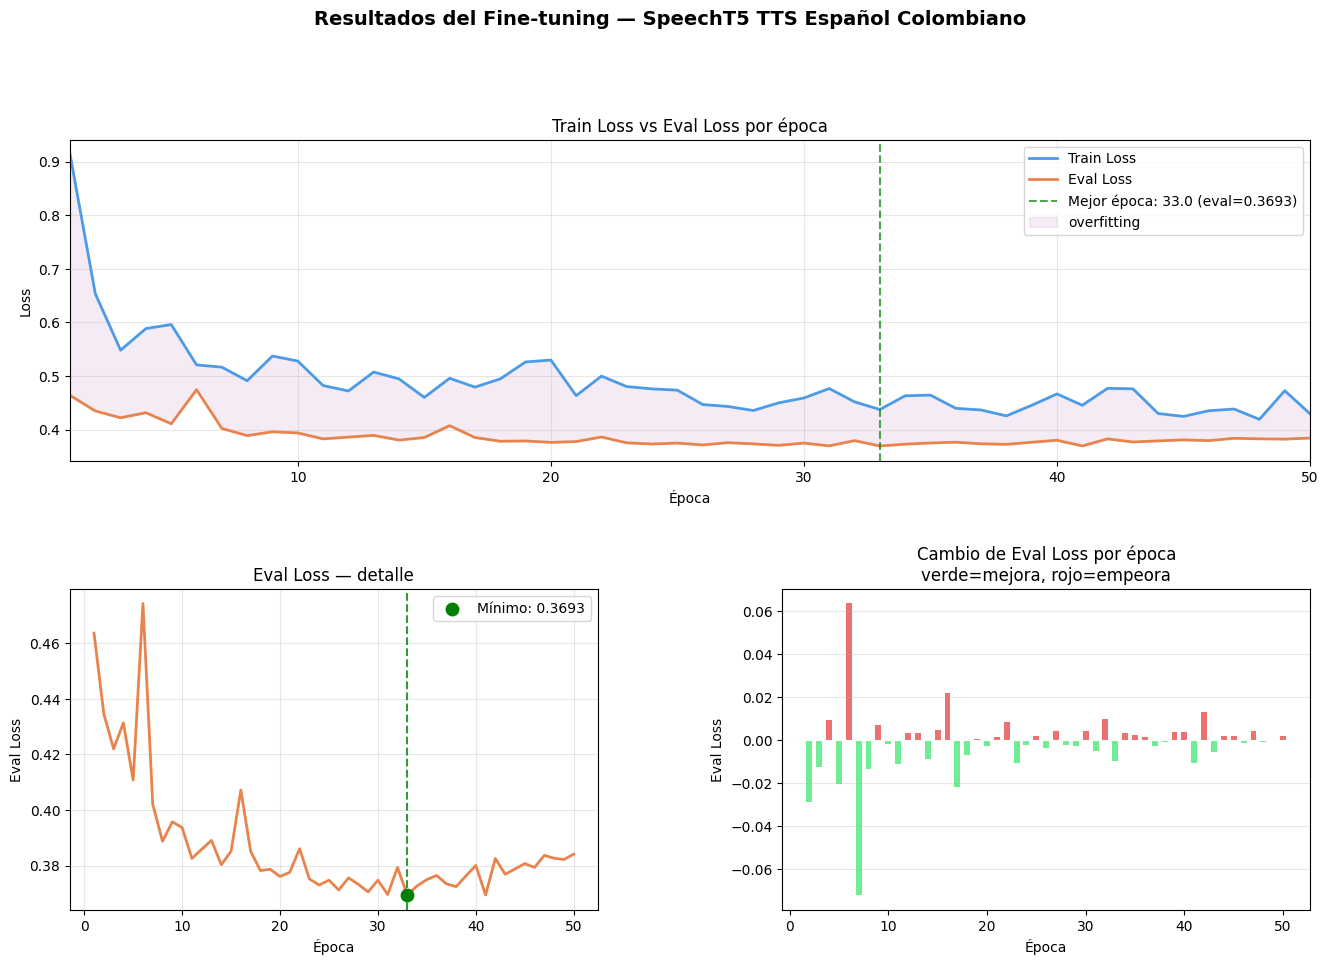

Épocas totales: 50
Mejor época: 33
Mejor eval loss: 0.3693
Train loss final: 0.4294
Eval loss inicial: 0.4637
Mejora total: 0.0944 (20.3%)
Overfitting (gap): 0.0453
Épocas sobreentrenadas: 17


In [46]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import json
import os

state_path = "./speecht5_tts_colombian/checkpoint-3550/trainer_state.json"
with open(state_path) as f:
    state = json.load(f)

epochs, train_loss, eval_loss = [], [], []
for log in state["log_history"]:
    if "eval_loss" in log:
        epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])

min_len = min(len(epochs), len(train_loss))
epochs     = epochs[:min_len]
train_loss = train_loss[:min_len]
eval_loss  = eval_loss[:min_len]

best_epoch = epochs[np.argmin(eval_loss)]
best_loss  = min(eval_loss)

fig = plt.figure(figsize=(16, 10))
fig.suptitle("Resultados del Fine-tuning — SpeechT5 TTS Español Colombiano", fontsize=14, fontweight="bold", y=1.01)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.35)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(epochs, train_loss, label="Train Loss", color="#4C9BE8", linewidth=2)
ax1.plot(epochs, eval_loss,  label="Eval Loss",  color="#E8834C", linewidth=2)
ax1.axvline(best_epoch, color="green", linestyle="--", alpha=0.7, label=f"Mejor época: {best_epoch} (eval={best_loss:.4f})")
ax1.fill_between(epochs, train_loss, eval_loss, alpha=0.08, color="purple", label="overfitting")
ax1.set_title("Train Loss vs Eval Loss por época")
ax1.set_xlabel("Época")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, max(epochs))

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(epochs, eval_loss, color="#E8834C", linewidth=2)
ax2.axvline(best_epoch, color="green", linestyle="--", alpha=0.8)
ax2.scatter([best_epoch], [best_loss], color="green", zorder=5, s=80, label=f"Mínimo: {best_loss:.4f}")
ax2.set_title("Eval Loss — detalle")
ax2.set_xlabel("Época")
ax2.set_ylabel("Eval Loss")
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
delta = np.diff(eval_loss)
ax3.bar(epochs[1:], delta, color=["#E84C4C" if d > 0 else "#4CE87A" for d in delta], alpha=0.8, width=0.6)
ax3.axhline(0, color="white", linewidth=0.8)
ax3.set_title("Cambio de Eval Loss por época\nverde=mejora, rojo=empeora")
ax3.set_xlabel("Época")
ax3.set_ylabel("Eval Loss")
ax3.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("training_results.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Épocas totales: {int(max(epochs))}")
print(f"Mejor época: {int(best_epoch)}")
print(f"Mejor eval loss: {best_loss:.4f}")
print(f"Train loss final: {train_loss[-1]:.4f}")
print(f"Eval loss inicial: {eval_loss[0]:.4f}")
print(f"Mejora total: {eval_loss[0] - best_loss:.4f} ({((eval_loss[0]-best_loss)/eval_loss[0])*100:.1f}%)")
print(f"Overfitting (gap): {train_loss[-1] - eval_loss[-1]:.4f}")

épocas_overfitting = next((i for i, e in enumerate(epochs) if e > best_epoch), None)
if épocas_overfitting:
    print(f"Épocas sobreentrenadas: {int(max(epochs)) - int(best_epoch)}")

In [41]:
embeddings = []
for i in range(20):
    audio = np.array(ds_combined[i]["audio"]["array"], dtype=np.float32)
    emb = get_speaker_embedding(audio)
    embeddings.append(emb)

spk_emb_avg = np.mean(embeddings, axis=0)
spk_emb_avg = spk_emb_avg / np.linalg.norm(spk_emb_avg)
spk_emb_avg = torch.tensor(spk_emb_avg).unsqueeze(0).to(DEVICE)

In [40]:
import soundfile as sf
from IPython.display import Audio as IPyAudio

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(DEVICE)
reference_audio = np.array(ds_combined[0]["audio"]["array"], dtype=np.float32)

speaker_emb = torch.tensor(get_speaker_embedding(reference_audio)).unsqueeze(0).to(DEVICE)

texto = "Tengo un problemon, se me acaba de pinchar una llanta"
inputs = processor(text=texto, return_tensors="pt").to(DEVICE)
model.eval().to(DEVICE)

with torch.no_grad():
    speech = model_inf.generate_speech(
        inputs["input_ids"],
        speaker_embeddings=spk_emb_avg,
        vocoder=vocoder,
        threshold=0.5,
        minlenratio=0.0,
        maxlenratio=10.0,
    )

sf.write("output_tts.wav", speech.cpu().numpy(), samplerate=16000)
IPyAudio("output_tts.wav")